<a href="https://colab.research.google.com/github/ktaran-jeet/deepfake-image-generation/blob/main/SignalGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Signal creation using feed-forward Generative Adversarial Network

In [3]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

Data generation

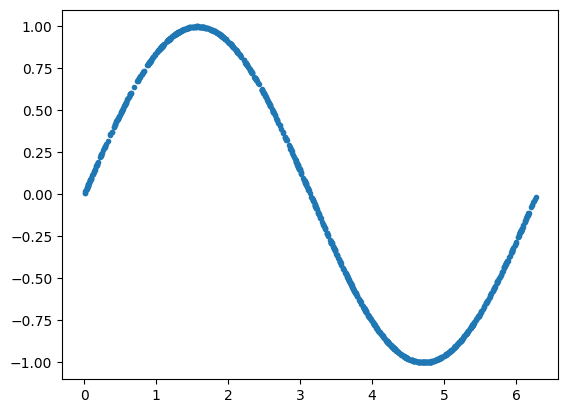

In [4]:
torch.manual_seed(111)
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
plt.plot(train_data[:, 0], train_data[:, 1], ".")

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

The generator is fed with random (z₁, z₂) pairs and is required to transform them so that they resemble the real samples.The discriminator D is fed with either real samples from the training dataset or generated samples provided by G. Its role is to estimate the probability that the input belongs to the real dataset. The training is performed so that D outputs 1 when it’s fed a real sample and 0 when it’s fed a generated sample.The GAN training process consists of a two-player minimax game in which D is adapted to minimize the discrimination error between real and generated samples, and G is adapted to maximize the probability of D making a mistake.

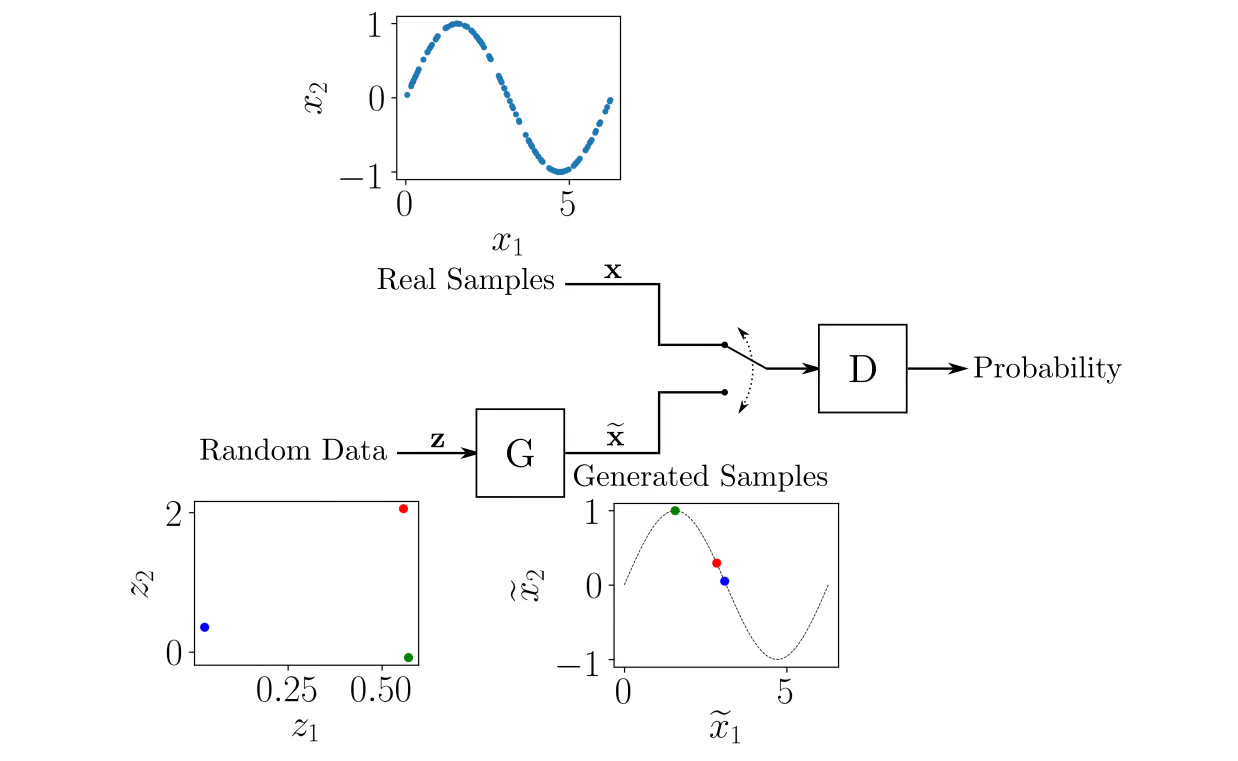

Generator and Discriminator model architecture:

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.model(x)

In [15]:
gen = Generator()
dis = Discriminator()

#Hyperparameters:
lr = 0.001
num_epochs = 300
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(dis.parameters(), lr=lr)
optimizerG = torch.optim.Adam(gen.parameters(), lr=lr)


for epoch in range(num_epochs):

    for i, data in enumerate(train_loader):
        dis.zero_grad()

        real_sample, _ = data
        target_real = torch.ones((batch_size,1))
        output_real = dis(real_sample)
        errdis_real = criterion(output_real, target_real)

        noise = torch.randn((batch_size, 2))
        fake_sample = gen(noise)
        target_fake = torch.zeros((batch_size,1))
        output_fake = dis(fake_sample.detach())
        errdis_fake = criterion(output_fake, target_fake)

        errdis = errdis_real + errdis_fake
        errdis.backward()
        optimizerD.step()

        gen.zero_grad()
        target_gen = torch.ones((batch_size,1))
        output_gen = dis(fake_sample)
        errgen = criterion(output_gen, target_gen)
        errgen.backward()
        optimizerG.step()


        if epoch % 10 == 0 and i == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {errdis.item()}")
            print(f"Epoch: {epoch} Loss G.: {errgen.item()}")

Epoch: 0 Loss D.: 0.3463252782821655
Epoch: 0 Loss G.: 2.8552982807159424
Epoch: 10 Loss D.: 1.3086566925048828
Epoch: 10 Loss G.: 0.8331876397132874
Epoch: 20 Loss D.: 1.0979876518249512
Epoch: 20 Loss G.: 0.9715311527252197
Epoch: 30 Loss D.: 1.4072383642196655
Epoch: 30 Loss G.: 0.7428874969482422
Epoch: 40 Loss D.: 1.1870412826538086
Epoch: 40 Loss G.: 0.9687570929527283
Epoch: 50 Loss D.: 1.3532195091247559
Epoch: 50 Loss G.: 0.7050118446350098
Epoch: 60 Loss D.: 1.2943079471588135
Epoch: 60 Loss G.: 0.8054498434066772
Epoch: 70 Loss D.: 1.3174177408218384
Epoch: 70 Loss G.: 0.7150459289550781
Epoch: 80 Loss D.: 1.3995474576950073
Epoch: 80 Loss G.: 0.6642335653305054
Epoch: 90 Loss D.: 1.3543305397033691
Epoch: 90 Loss G.: 0.7375721335411072
Epoch: 100 Loss D.: 1.3216599225997925
Epoch: 100 Loss G.: 0.766032338142395
Epoch: 110 Loss D.: 1.3455668687820435
Epoch: 110 Loss G.: 0.7869313955307007
Epoch: 120 Loss D.: 1.3494504690170288
Epoch: 120 Loss G.: 0.7180865406990051
Epoch: 13

Testing the trained generator:Looks good enough like a sine curve even with simple feed-forward nn.

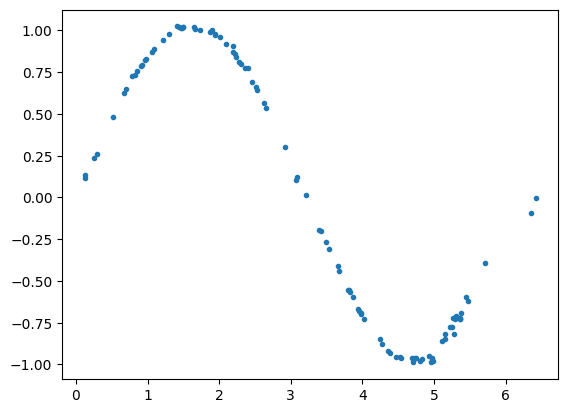

In [16]:
test_sample = torch.randn(100, 2)
generated_op = gen(test_sample)
generated_op = generated_op.detach()
plt.plot(generated_op[:, 0], generated_op[:, 1], ".")